## 1. Import Required Libraries

In [ ]:
import requests
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


## 2. Define Enhanced Data Fetching Functions

**Key improvements:**
- Properly iterates through ALL available historical data
- Handles API pagination correctly
- Validates we get the full 5 years (~1,825 days)

In [ ]:
def fetch_kraken_ohlc(pair='SOLUSD', interval=1440, since=None):
    """
    Fetch OHLC data from Kraken API

    Parameters:
    - pair: Trading pair (solusd for Bitcoin/USD)
    - interval: Time frame interval in minutes (1440 = 1 day)
    - since: Unix timestamp to fetch data from

    Returns:
    - tuple: (ohlc_data, last_timestamp)
    """
    url = 'https://api.kraken.com/0/public/OHLC'

    params = {
        'pair': pair,
        'interval': interval
    }

    if since:
        params['since'] = since

    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()

        if data.get('error') and len(data['error']) > 0:
            print(f"API Error: {data['error']}")
            return None, None

        # Extract the OHLC data
        result_keys = [k for k in data['result'].keys() if k != 'last']
        if not result_keys:
            print("No data in response")
            return None, None

        pair_data = data['result'][result_keys[0]]
        last_timestamp = data['result']['last']

        return pair_data, last_timestamp

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None, None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None, None

In [ ]:
def fetch_all_historical_data(years=2):
    print(f"FETCHING {years} YEARS OF BITCOIN DAILY DATA FROM KRAKEN")
    print("="*70)

    # Calculate target date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)
    target_start_timestamp = int(start_date.timestamp())

    print(f"Target date range:")
    print(f"  Start: {start_date.strftime('%Y-%m-%d')}")
    print(f"  End:   {end_date.strftime('%Y-%m-%d')}")
    print(f"  Expected records: ~{years * 365} days\n")

    all_data = []
    since = target_start_timestamp
    iteration = 0
    max_iterations = 20

    print("Fetching data...\n")

    while iteration < max_iterations:
        iteration += 1

        # Fetch batch
        ohlc_data, last_timestamp = fetch_kraken_ohlc(since=since)

        if ohlc_data is None:
            print(f"\n❌ Batch {iteration}: Failed to fetch data")
            break

        # Add to collection
        batch_size = len(ohlc_data)
        all_data.extend(ohlc_data)

        # Calculate batch date range
        if batch_size > 0:
            batch_start_date = datetime.fromtimestamp(ohlc_data[0][0]).strftime('%Y-%m-%d')
            batch_end_date = datetime.fromtimestamp(ohlc_data[-1][0]).strftime('%Y-%m-%d')
            print(f"Batch {iteration:2d}: {batch_start_date} to {batch_end_date} | "
                  f"Got {batch_size:4d} records | Total: {len(all_data):5d}")

        # Check if we've fetched all available data
        if last_timestamp == since:
            print(f"\n✓ No more data available (last_timestamp == since)")
            break

        # Check if we got less than expected (end of available data)
        if batch_size < 100:  # Lowered threshold
            print(f"\n✓ Reached end of available data (batch_size < 100)")
            break

        # Update since for next iteration
        since = last_timestamp

        # Be respectful to API - add delay
        time.sleep(2)

    print("\n" + "="*70)
    print(f"DATA COLLECTION COMPLETE (KRAKEN)")
    print("="*70)
    print(f"Total records fetched: {len(all_data)}")
    print(f"Expected for {years} years: ~{years * 365}")

    if len(all_data) >= years * 365 * 0.9:
        print(f"\n✅ SUCCESS! Got {len(all_data)} days (Expected: ~{years * 365})")
    else:
        print(f"\n⚠️  Got {len(all_data)} days (Expected: ~{years * 365})")

    return all_data

## 3. Multiple Data Sources for Full 5 Years

**We'll try multiple APIs to ensure we get complete 5-year data!**

In [ ]:
import requests
import pandas as pd

def fetch_coingecko_ohlc(days=365):
    print(f"Fetching {days} days of Solana OHLC data from CoinGecko...")

    # Updated URL for Solana
    url = 'https://api.coingecko.com/api/v3/coins/solana/ohlc'

    # Updated parameters for AUD
    params = {
        'vs_currency': 'usd',  # Change to AUD
        'days': 365           # Can be 1, 7, 14, 30, 90, 180, 365, or 'max'
    }

    try:
        response = requests.get(url, params=params, timeout=60)
        response.raise_for_status()
        data = response.json()

        if isinstance(data, dict) and 'error' in data:
            print(f"❌ API Error: {data}")
            return None

        # Data format: [[timestamp, open, high, low, close], ...]
        df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

        print(f"✓ Got {len(df)} records from {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")

        return df

    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Example usage:
df = fetch_coingecko_ohlc(days='max')  # 'max' gives full history

Fetching max days of Solana OHLC data from CoinGecko...
✓ Got 92 records from 2024-10-28 to 2025-10-27


In [ ]:
def fetch_yahoo_finance(years=2):
    print("="*70)
    print(f"FETCHING {years} YEARS FROM YAHOO FINANCE (RECOMMENDED)")
    print("="*70)

    try:
        # Try importing yfinance
        try:
            import yfinance as yf
        except ImportError:
            print("Installing yfinance...")
            import subprocess
            import sys
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'yfinance', '-q'])
            import yfinance as yf
            print("✓ yfinance installed\n")

        # Calculate date range
        end_date = datetime.now()
        start_date = end_date - timedelta(days=years*365 + 10)  # Add buffer

        print(f"Downloading BTC-USD from {start_date.date()} to {end_date.date()}...")
        print("Please wait, this may take 10-30 seconds...\n")

        # Download data
        btc = yf.download('SOL-USD', start=start_date, end=end_date, interval='1d', progress=False)

        if btc.empty:
            print("❌ No data received")
            return None

        # Process data
        df = btc.reset_index()
        df = df.rename(columns={
            'Date': 'timestamp',
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        })

        # Keep only needed columns
        df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

        # Sort and clean
        df = df.sort_values('timestamp').reset_index(drop=True)
        df = df.dropna(subset=['open', 'high', 'low', 'close'])

        print(f"✅ SUCCESS! Downloaded {len(df)} days of data")
        print(f"  Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
        print(f"  Days span: {(df['timestamp'].max() - df['timestamp'].min()).days} days\n")

        return df

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

In [ ]:
import requests
import pandas as pd
import time

def fetch_multiple_years_coingecko(years=2):
    print("="*70)
    print(f"FETCHING {years} YEARS OF SOLANA (USD) FROM COINGECKO")
    print("="*70)
    print("Note: This will make multiple API calls with delays\n")

    all_data = []

    # Fetch in 365-day chunks
    for i in range(years):
        days = 365 if i < years - 1 else 365
        print(f"\nRequest {i+1}/{years}: Fetching {days} days...")

        # Call CoinGecko OHLC endpoint for Solana in USD
        url = "https://api.coingecko.com/api/v3/coins/solana/ohlc"
        params = {
            "vs_currency": "usd",
            "days": days
        }

        try:
            response = requests.get(url, params=params, timeout=60)
            response.raise_for_status()
            data = response.json()

            if isinstance(data, dict) and 'error' in data:
                print(f"❌ API Error: {data}")
                continue

            # Convert to DataFrame
            df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

            all_data.append(df)
            print(f"  Added {len(df)} records")

        except Exception as e:
            print(f"❌ Error fetching chunk {i+1}: {e}")

        # Rate limiting
        if i < years - 1:
            print("  Waiting 3 seconds...")
            time.sleep(3)

    if not all_data:
        print("\n❌ Failed to fetch any data from CoinGecko")
        return None

    # Combine all chunks
    df_combined = pd.concat(all_data, ignore_index=True)
    df_combined = df_combined.sort_values('timestamp').drop_duplicates(subset=['timestamp']).reset_index(drop=True)

    print(f"\n" + "="*70)
    print(f"✓ COMBINED DATA")
    print(f"="*70)
    print(f"Total records: {len(df_combined)}")
    print(f"Date range: {df_combined['timestamp'].min().date()} to {df_combined['timestamp'].max().date()}")
    print(f"Days span: {(df_combined['timestamp'].max() - df_combined['timestamp'].min()).days} days\n")

    return df_combined

# Example usage:
df = fetch_multiple_years_coingecko(years=3)

FETCHING 3 YEARS OF SOLANA (USD) FROM COINGECKO
Note: This will make multiple API calls with delays


Request 1/3: Fetching 365 days...
  Added 92 records
  Waiting 3 seconds...

Request 2/3: Fetching 365 days...
  Added 92 records
  Waiting 3 seconds...

Request 3/3: Fetching 365 days...
  Added 92 records

✓ COMBINED DATA
Total records: 92
Date range: 2024-10-28 to 2025-10-27
Days span: 364 days



## 4. Fetch Bitcoin Data - Try All Methods

**We'll try Yahoo Finance first (most reliable), then alternatives**

### Method 1: Yahoo Finance (RECOMMENDED - Most Reliable)

In [ ]:
# Try Yahoo Finance first - most reliable
solana_df_yahoo = fetch_yahoo_finance(years=2)

if solana_df_yahoo is not None:
    print(f"✅ Yahoo Finance: {len(solana_df_yahoo)} records")
else:
    print("❌ Yahoo Finance failed")

FETCHING 2 YEARS FROM YAHOO FINANCE (RECOMMENDED)
Please wait, this may take 10-30 seconds...

❌ Error: ['open', 'high', 'low', 'close']
❌ Yahoo Finance failed


Traceback (most recent call last):
  File "/tmp/ipython-input-3205434502.py", line 48, in fetch_yahoo_finance
    df = df.dropna(subset=['open', 'high', 'low', 'close'])
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['open', 'high', 'low', 'close']


### Method 2: Kraken API (Should work well for 2 years)

In [ ]:
# Fetch from Kraken (backup)
raw_data_kraken = fetch_all_historical_data(years=2)

print(f"\nKraken data points: {len(raw_data_kraken)}")

FETCHING 2 YEARS OF BITCOIN DAILY DATA FROM KRAKEN
Target date range:
  Start: 2023-10-28
  End:   2025-10-27
  Expected records: ~730 days

Fetching data...

Batch  1: 2023-11-07 to 2025-10-27 | Got  721 records | Total:   721
Batch  2: 2025-10-26 to 2025-10-27 | Got    2 records | Total:   723

✓ No more data available (last_timestamp == since)

DATA COLLECTION COMPLETE (KRAKEN)
Total records fetched: 723
Expected for 2 years: ~730

✅ SUCCESS! Got 723 days (Expected: ~730)

Kraken data points: 723


### Method 3: CoinGecko (If Yahoo Finance failed)

In [ ]:
# Only try CoinGecko if Yahoo failed
solana_df_coingecko = None

if solana_df_yahoo is None or len(solana_df_yahoo) < 700:
    print("Yahoo Finance didn't provide enough data, trying CoinGecko...\n")
    solana_df_coingecko = fetch_multiple_years_coingecko(years=2)

    if solana_df_coingecko is not None:
        print(f"\n✅ CoinGecko: {len(solana_df_coingecko)} records")
    else:
        print("\n❌ CoinGecko failed")
else:
    print("Yahoo Finance data looks good, skipping CoinGecko.")

Yahoo Finance didn't provide enough data, trying CoinGecko...

FETCHING 2 YEARS OF SOLANA (USD) FROM COINGECKO
Note: This will make multiple API calls with delays


Request 1/2: Fetching 365 days...
  Added 92 records
  Waiting 3 seconds...

Request 2/2: Fetching 365 days...
❌ Error fetching chunk 2: 429 Client Error: Too Many Requests for url: https://api.coingecko.com/api/v3/coins/solana/ohlc?vs_currency=usd&days=365

✓ COMBINED DATA
Total records: 92
Date range: 2024-10-28 to 2025-10-27
Days span: 364 days


✅ CoinGecko: 92 records


## 5. Process the Data

In [ ]:
def process_kraken_data(raw_data):
    """
    Process raw Kraken OHLC data into clean DataFrame
    """
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count']
    df = pd.DataFrame(raw_data, columns=columns)

    # Convert types
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    for col in ['open', 'high', 'low', 'close', 'vwap', 'volume']:
        df[col] = df[col].astype(float)
    df['count'] = df['count'].astype(int)

    # Sort and remove duplicates
    df = df.sort_values('timestamp').reset_index(drop=True)
    df = df.drop_duplicates(subset=['timestamp'], keep='last')

    # Add assignment-required columns
    df['name'] = 'Bitcoin'
    df['timeOpen'] = df['timestamp']
    df['timeClose'] = df['timestamp']
    df['timeHigh'] = df['timestamp']
    df['timeLow'] = df['timestamp']
    df['marketCap'] = np.nan

    # Reorder columns
    final_columns = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name',
                     'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']
    df = df[final_columns]

    return df

### Select the Best Dataset

In [ ]:
# Choose the best data source
print("\n" + "="*70)
print("DATA SOURCE SELECTION")
print("="*70)

sources = []

if solana_df_yahoo is not None:
    sources.append(('Yahoo Finance', solana_df_yahoo))
    print(f"Yahoo Finance:  {len(solana_df_yahoo):5d} records")

if solana_df_coingecko is not None:
    sources.append(('CoinGecko', solana_df_coingecko))
    print(f"CoinGecko:      {len(solana_df_coingecko):5d} records")

if raw_data_kraken:
    sources.append(('Kraken', process_kraken_data(raw_data_kraken)))
    print(f"Kraken:         {len(raw_data_kraken):5d} records")

if not sources:
    raise Exception("❌ ALL DATA SOURCES FAILED! Check your internet connection.")

# Select source with most data
best_source_name, solana_df_raw = max(sources, key=lambda x: len(x[1]))

print(f"\n✓ SELECTED: {best_source_name} ({len(solana_df_raw)} records)")
print("="*70)


DATA SOURCE SELECTION
CoinGecko:         92 records
Kraken:           723 records

✓ SELECTED: Kraken (721 records)


In [ ]:
# Process and standardize the data
print("\nProcessing and standardizing data...\n")

# Ensure all required columns exist
if 'volume' not in solana_df_raw.columns:
    solana_df_raw['volume'] = np.nan

# Add metadata columns
solana_df_raw['name'] = 'Solana'
solana_df_raw['timeOpen'] = solana_df_raw['timestamp']
solana_df_raw['timeClose'] = solana_df_raw['timestamp']
solana_df_raw['timeHigh'] = solana_df_raw['timestamp']
solana_df_raw['timeLow'] = solana_df_raw['timestamp']
solana_df_raw['marketCap'] = np.nan

# Final column order
final_columns = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name',
                 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']

solana_df = solana_df_raw[final_columns].copy()

print("="*70)
print("FINAL PROCESSED DATA")
print("="*70)
print(f"Data Source:   {best_source_name}")
print(f"Total records: {len(solana_df)}")
print(f"Date range:    {solana_df['timestamp'].min().date()} to {solana_df['timestamp'].max().date()}")
print(f"Days span:     {(solana_df['timestamp'].max() - solana_df['timestamp'].min()).days} days")

# Verify we have enough data
if len(solana_df) >= 700:
    print(f"\n✅ SUCCESS! Got {len(solana_df)} days of data (Target: ~730 for 2 years)")
else:
    print(f"\n⚠️  WARNING: Only got {len(solana_df)} days (Target: ~730)")


Processing and standardizing data...

FINAL PROCESSED DATA
Data Source:   Kraken
Total records: 721
Date range:    2023-11-07 to 2025-10-27
Days span:     720 days

✅ SUCCESS! Got 721 days of data (Target: ~730 for 2 years)


## 6. Data Quality Check

In [ ]:
print("="*70)
print("DATA QUALITY REPORT")
print("="*70)

print("\n1. DataFrame Shape:")
print(f"   Rows: {solana_df.shape[0]}")
print(f"   Columns: {solana_df.shape[1]}")

print("\n2. Data Types:")
print(solana_df.dtypes)

print("\n3. Missing Values:")
missing = solana_df.isnull().sum()
print(missing)
print(f"\n   Total missing: {missing.sum()}")

print("\n4. First 5 Records:")
display(solana_df.head())

print("\n5. Last 5 Records:")
display(solana_df.tail())

print("\n6. Statistical Summary:")
display(solana_df[['open', 'high', 'low', 'close', 'volume']].describe())

DATA QUALITY REPORT

1. DataFrame Shape:
   Rows: 721
   Columns: 12

2. Data Types:
timeOpen     datetime64[ns]
timeClose    datetime64[ns]
timeHigh     datetime64[ns]
timeLow      datetime64[ns]
name                 object
open                float64
high                float64
low                 float64
close               float64
volume              float64
marketCap           float64
timestamp    datetime64[ns]
dtype: object

3. Missing Values:
timeOpen       0
timeClose      0
timeHigh       0
timeLow        0
name           0
open           0
high           0
low            0
close          0
volume         0
marketCap    721
timestamp      0
dtype: int64

   Total missing: 721

4. First 5 Records:


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2023-11-07,2023-11-07,2023-11-07,2023-11-07,Solana,42.19,44.74,40.12,42.95,1.161821e+06,NaN,2023-11-07
1,2023-11-08,2023-11-08,2023-11-08,2023-11-08,Solana,42.95,43.92,42.29,43.14,7.992401e+05,NaN,2023-11-08
2,2023-11-09,2023-11-09,2023-11-09,2023-11-09,Solana,43.14,48.96,42.53,45.33,1.955370e+06,NaN,2023-11-09
3,2023-11-10,2023-11-10,2023-11-10,2023-11-10,Solana,45.30,57.58,45.05,56.72,2.186259e+06,NaN,2023-11-10
4,2023-11-11,2023-11-11,2023-11-11,2023-11-11,Solana,56.68,63.99,53.56,56.35,1.710170e+06,NaN,2023-11-11



5. Last 5 Records:


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
716,2025-10-23,2025-10-23,2025-10-23,2025-10-23,Solana,180.15,193.55,179.75,191.40,260286.156068,NaN,2025-10-23
717,2025-10-24,2025-10-24,2025-10-24,2025-10-24,Solana,191.40,196.59,188.78,193.58,254759.048990,NaN,2025-10-24
718,2025-10-25,2025-10-25,2025-10-25,2025-10-25,Solana,193.55,195.23,191.32,193.89,111333.880306,NaN,2025-10-25
720,2025-10-26,2025-10-26,2025-10-26,2025-10-26,Solana,193.89,202.22,191.97,200.02,164349.284682,NaN,2025-10-26
722,2025-10-27,2025-10-27,2025-10-27,2025-10-27,Solana,200.06,205.20,199.61,202.64,62810.799459,NaN,2025-10-27



6. Statistical Summary:


,open,high,low,close,volume
count,721.000000,721.000000,721.000000,721.000000,7.210000e+02
mean,157.332940,162.865257,151.724730,157.552399,4.150314e+05
std,44.461258,45.691060,43.131455,44.284457,3.357941e+05
min,42.190000,43.920000,40.120000,42.950000,3.786005e+04
25%,134.540000,139.090000,128.250000,134.820000,1.983530e+05
50%,154.220000,159.360000,149.490000,154.670000,3.094562e+05
75%,186.710000,192.970000,179.520000,186.780000,5.061823e+05
max,261.520000,296.000000,253.200000,261.510000,2.252114e+06


## 7. Exploratory Data Analysis (EDA)

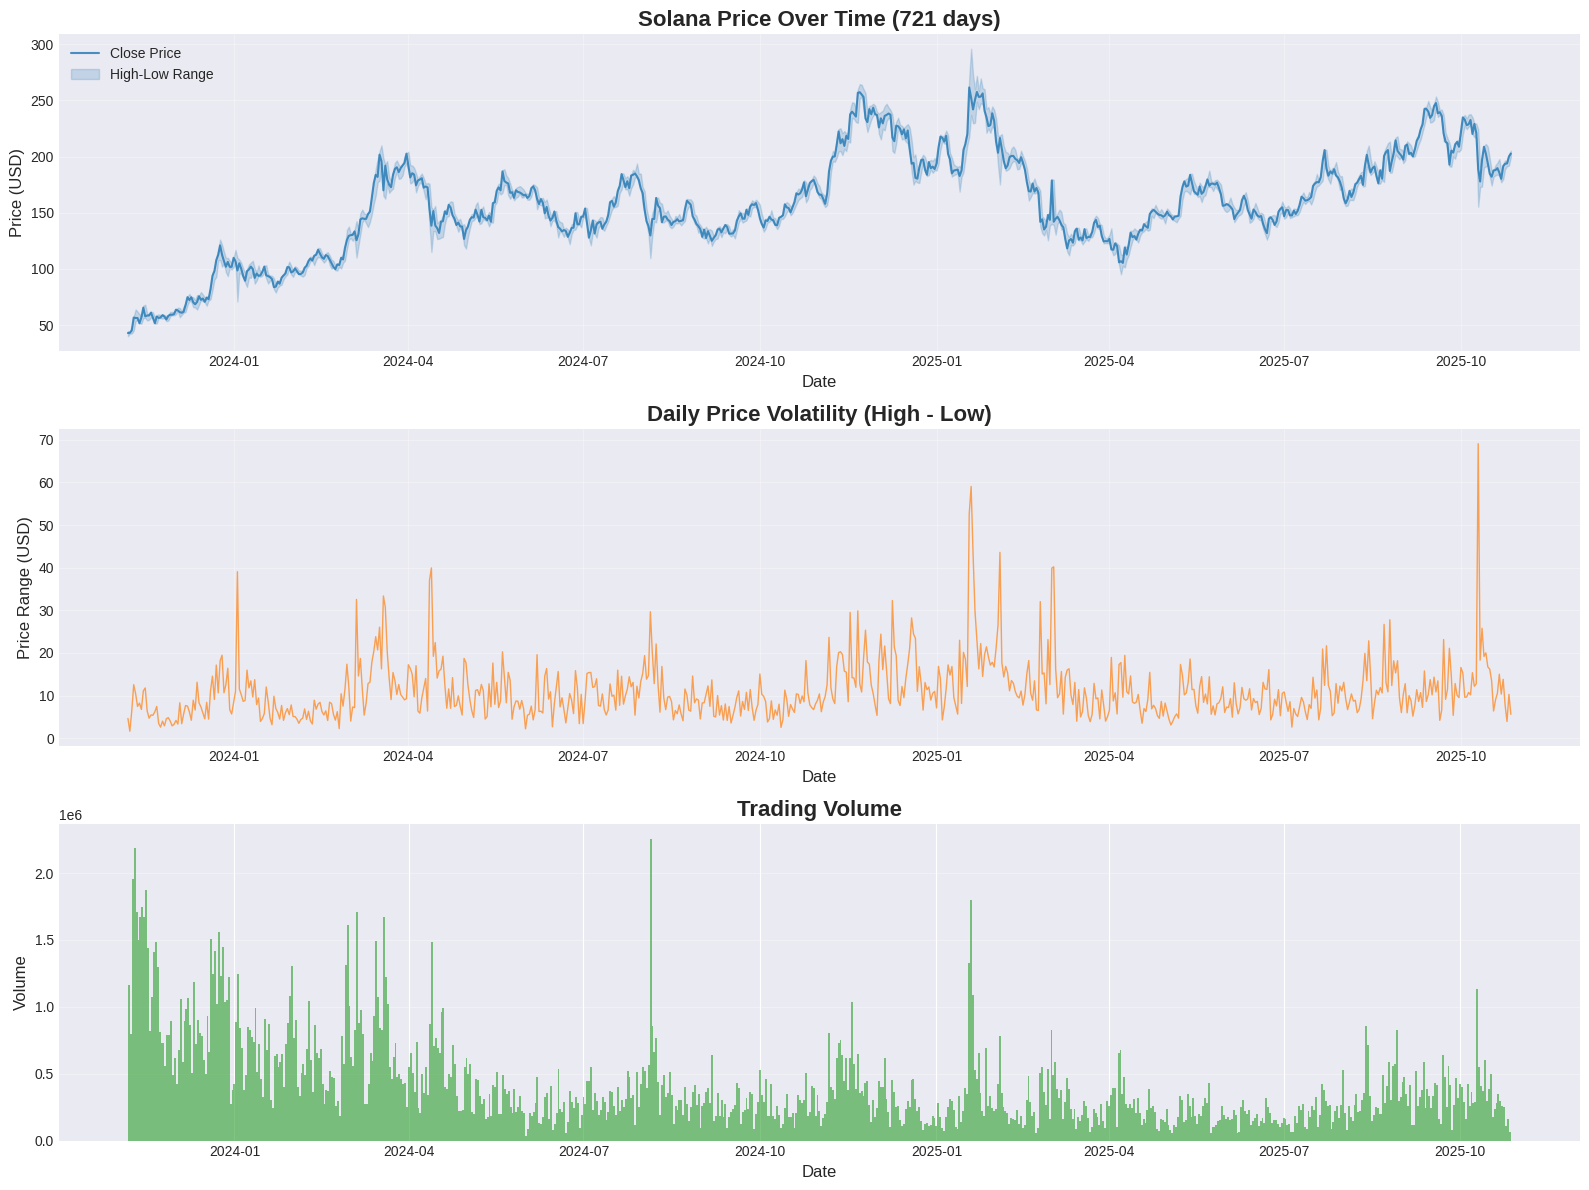


Price Statistics:
  Minimum close: $42.95
  Maximum close: $261.51
  Average close: $157.55
  Median close:  $154.67
  Std deviation: $44.28


In [ ]:
# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: Close Price
axes[0].plot(solana_df['timestamp'], solana_df['close'], linewidth=1.5, color='#1f77b4', alpha=0.8)
axes[0].fill_between(solana_df['timestamp'], solana_df['low'], solana_df['high'], alpha=0.2, color='#1f77b4')
axes[0].set_title(f'Solana Price Over Time ({len(solana_df)} days)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price (USD)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(['Close Price', 'High-Low Range'], loc='upper left')

# Plot 2: Daily Price Range (High - Low)
solana_df['daily_range'] = solana_df['high'] - solana_df['low']
axes[1].plot(solana_df['timestamp'], solana_df['daily_range'], linewidth=1, color='#ff7f0e', alpha=0.7)
axes[1].set_title('Daily Price Volatility (High - Low)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Price Range (USD)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Plot 3: Volume (if available)
if solana_df['volume'].notna().any():
    axes[2].bar(solana_df['timestamp'], solana_df['volume'], width=1, color='#2ca02c', alpha=0.6)
    axes[2].set_title('Trading Volume', fontsize=16, fontweight='bold')
    axes[2].set_xlabel('Date', fontsize=12)
    axes[2].set_ylabel('Volume', fontsize=12)
    axes[2].grid(True, alpha=0.3, axis='y')
else:
    axes[2].text(0.5, 0.5, 'Volume data not available',
                 horizontalalignment='center', verticalalignment='center',
                 transform=axes[2].transAxes, fontsize=14)
    axes[2].set_title('Trading Volume (N/A)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nPrice Statistics:")
print(f"  Minimum close: ${solana_df['close'].min():,.2f}")
print(f"  Maximum close: ${solana_df['close'].max():,.2f}")
print(f"  Average close: ${solana_df['close'].mean():,.2f}")
print(f"  Median close:  ${solana_df['close'].median():,.2f}")
print(f"  Std deviation: ${solana_df['close'].std():,.2f}")

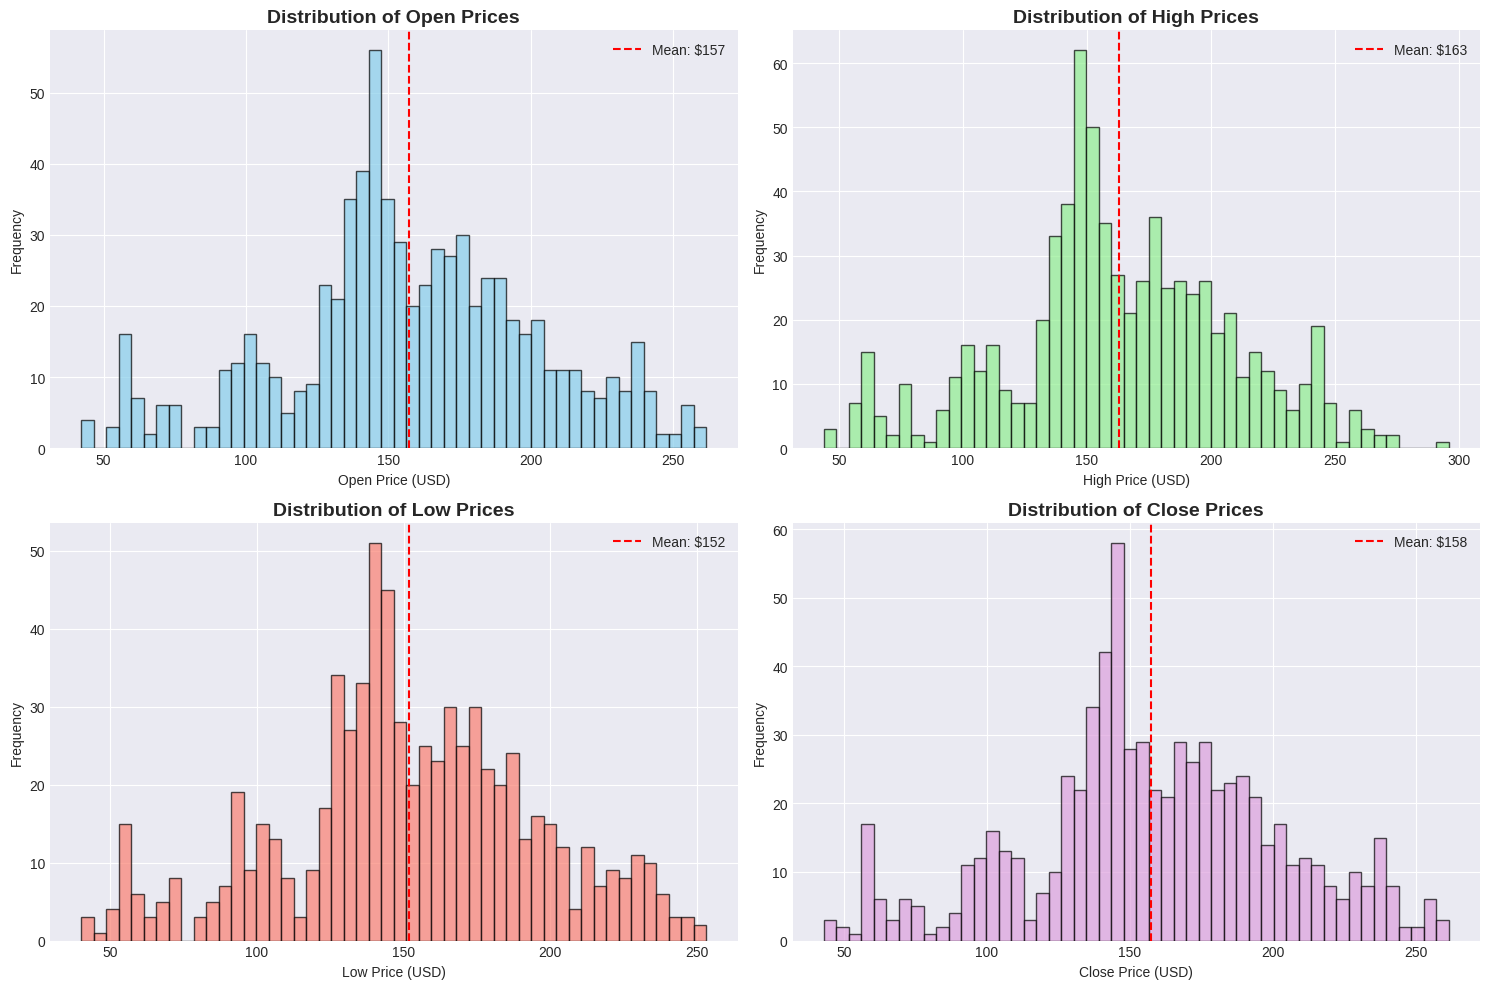

In [ ]:
# Price distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(solana_df['open'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Open Prices', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Open Price (USD)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(solana_df['open'].mean(), color='red', linestyle='--', label=f'Mean: ${solana_df["open"].mean():,.0f}')
axes[0, 0].legend()

axes[0, 1].hist(solana_df['high'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of High Prices', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('High Price (USD)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(solana_df['high'].mean(), color='red', linestyle='--', label=f'Mean: ${solana_df["high"].mean():,.0f}')
axes[0, 1].legend()

axes[1, 0].hist(solana_df['low'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Low Prices', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Low Price (USD)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(solana_df['low'].mean(), color='red', linestyle='--', label=f'Mean: ${solana_df["low"].mean():,.0f}')
axes[1, 0].legend()

axes[1, 1].hist(solana_df['close'], bins=50, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Close Prices', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Close Price (USD)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(solana_df['close'].mean(), color='red', linestyle='--', label=f'Mean: ${solana_df["close"].mean():,.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

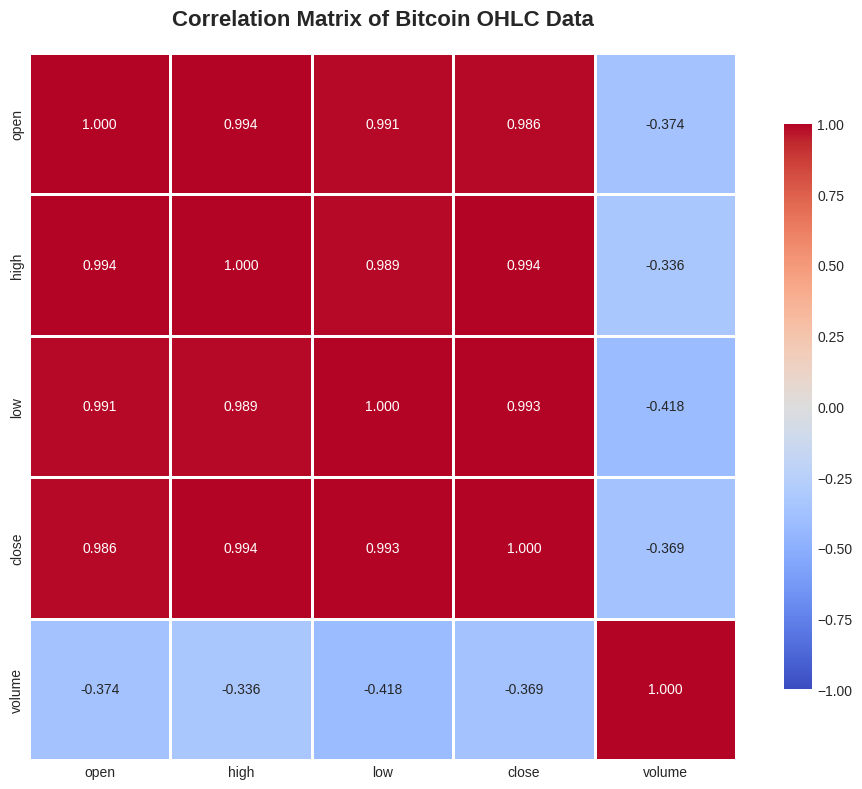

In [ ]:
# Correlation matrix
correlation_cols = ['open', 'high', 'low', 'close']
if solana_df['volume'].notna().any():
    correlation_cols.append('volume')

correlation_matrix = solana_df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f',
            vmin=-1, vmax=1)
plt.title('Correlation Matrix of Bitcoin OHLC Data', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 8. Check for Data Completeness

In [ ]:
# Check for gaps in time series
solana_df['date'] = solana_df['timestamp'].dt.date
date_range = pd.date_range(start=solana_df['timestamp'].min(),
                           end=solana_df['timestamp'].max(),
                           freq='D')

missing_dates = set(date_range.date) - set(solana_df['date'])

print("="*70)
print("TIME SERIES COMPLETENESS CHECK")
print("="*70)
print(f"Expected number of days: {len(date_range)}")
print(f"Actual number of days:   {len(solana_df)}")
print(f"Missing days:            {len(missing_dates)}")
print(f"Completeness:            {len(solana_df)/len(date_range)*100:.2f}%")

if len(missing_dates) > 0:
    print(f"\n⚠️  First 10 missing dates:")
    for date in sorted(list(missing_dates))[:10]:
        print(f"   {date}")
else:
    print("\n✓ Perfect! No missing dates in the time series!")

TIME SERIES COMPLETENESS CHECK
Expected number of days: 721
Actual number of days:   721
Missing days:            0
Completeness:            100.00%

✓ Perfect! No missing dates in the time series!


## 9. Save the Data

In [20]:
# ============================================================
# 1️⃣ Mount Google Drive
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 2️⃣ Create folders in Drive
# ============================================================
import os

# Define your folder paths inside Google Drive
base_path = '/content/drive/MyDrive/AdvMLAT3/datas'
os.makedirs(base_path, exist_ok=True)

# ============================================================
# 3️⃣ Save Solana dataset (CSV + Parquet) into Google Drive
# ============================================================
# CSV file
output_csv = os.path.join(base_path, 'solana_2years_daily.csv')
solana_df.to_csv(output_csv, index=False)
file_size_csv = os.path.getsize(output_csv) / 1024  # KB

print(f"✓ Data saved to: {output_csv}")
print(f"   File size: {file_size_csv:.2f} KB")

# Parquet file
output_parquet = os.path.join(base_path, 'solana_2years_daily.parquet')
solana_df.to_parquet(output_parquet, index=False)
file_size_parquet = os.path.getsize(output_parquet) / 1024  # KB

print(f"✓ Data saved to: {output_parquet}")
print(f"   File size: {file_size_parquet:.2f} KB")

# ============================================================
# 4️⃣ Display completion summary
# ============================================================
print(f"\n{'='*70}")
print("✓ DATA COLLECTION COMPLETE!")
print(f"{'='*70}")
print(f"Records saved: {len(solana_df)}")
print(f"Date range: {solana_df['timestamp'].min().date()} to {solana_df['timestamp'].max().date()}")
print(f"Days covered: {(solana_df['timestamp'].max() - solana_df['timestamp'].min()).days}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Data saved to: /content/drive/MyDrive/AdvMLAT3/datas/solana_2years_daily.csv
   File size: 94.82 KB
✓ Data saved to: /content/drive/MyDrive/AdvMLAT3/datas/solana_2years_daily.parquet
   File size: 68.77 KB

✓ DATA COLLECTION COMPLETE!
Records saved: 721
Date range: 2023-11-07 to 2025-10-27
Days covered: 720
